In [1]:
#!/usr/bin/python
# -*- coding:utf-8 -*-

import numpy as np
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def test_clf(clf):
    print u'分类器：', clf
    alpha_can = np.logspace(-3, 2, 10)
    model = GridSearchCV(clf, param_grid={'alpha': alpha_can}, cv=5)
    m = alpha_can.size
    if hasattr(clf, 'alpha'):
        model.set_params(param_grid={'alpha': alpha_can})
        m = alpha_can.size
    if hasattr(clf, 'n_neighbors'):
        neighbors_can = np.arange(1, 15)
        model.set_params(param_grid={'n_neighbors': neighbors_can})
        m = neighbors_can.size
    if hasattr(clf, 'C'):
        C_can = np.logspace(1, 3, 3)
        gamma_can = np.logspace(-3, 0, 3)
        model.set_params(param_grid={'C':C_can, 'gamma':gamma_can})
        m = C_can.size * gamma_can.size
    if hasattr(clf, 'max_depth'):
        max_depth_can = np.arange(4, 10)
        model.set_params(param_grid={'max_depth': max_depth_can})
        m = max_depth_can.size
    t_start = time()
    model.fit(x_train, y_train)
    t_end = time()
    t_train = (t_end - t_start) / (5*m)
    print u'5折交叉验证的训练时间为：%.3f秒/(5*%d)=%.3f秒' % ((t_end - t_start), m, t_train)
    print u'最优超参数为：', model.best_params_
    t_start = time()
    y_hat = model.predict(x_test)
    t_end = time()
    t_test = t_end - t_start
    print u'测试时间：%.3f秒' % t_test
    acc = metrics.accuracy_score(y_test, y_hat)
    print u'测试集准确率：%.2f%%' % (100 * acc)
    name = str(clf).split('(')[0]
    index = name.find('Classifier')
    if index != -1:
        name = name[:index]     # 去掉末尾的Classifier
    if name == 'SVC':
        name = 'SVM'
    return t_train, t_test, 1-acc, name

In [3]:
if __name__ == "__main__":
    print u'开始下载/加载数据...'
    t_start = time()
    # remove = ('headers', 'footers', 'quotes')
    remove = ()
    categories = 'alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space'
    # categories = None     # 若分类所有类别，请注意内存是否够用
    data_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=0, remove=remove)
    data_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=0, remove=remove)
    t_end = time()
    print u'下载/加载数据完成，耗时%.3f秒' % (t_end - t_start)
    print u'数据类型：', type(data_train)
    print u'训练集包含的文本数目：', len(data_train.data)
    print u'测试集包含的文本数目：', len(data_test.data)
    print u'训练集和测试集使用的%d个类别的名称：' % len(categories)
    categories = data_train.target_names
    pprint(categories)
    y_train = data_train.target
    y_test = data_test.target
    print u' -- 前10个文本 -- '
    for i in np.arange(10):
        print u'文本%d(属于类别 - %s)：' % (i+1, categories[y_train[i]])
        print data_train.data[i]
        print '\n\n'
    vectorizer = TfidfVectorizer(input='content', stop_words='english', max_df=0.5, sublinear_tf=True)
    x_train = vectorizer.fit_transform(data_train.data)  # x_train是稀疏的，scipy.sparse.csr.csr_matrix
    x_test = vectorizer.transform(data_test.data)
    print u'训练集样本个数：%d，特征个数：%d' % x_train.shape
    print u'停止词:\n',
    pprint(vectorizer.get_stop_words())
    feature_names = np.asarray(vectorizer.get_feature_names())

    print u'\n\n===================\n分类器的比较：\n'
    clfs = (MultinomialNB(),                # 0.87(0.017), 0.002, 90.39%
            BernoulliNB(),                  # 1.592(0.032), 0.010, 88.54%
            KNeighborsClassifier(),         # 19.737(0.282), 0.208, 86.03%
            RidgeClassifier(),              # 25.6(0.512), 0.003, 89.73%
            RandomForestClassifier(n_estimators=200),   # 59.319(1.977), 0.248, 77.01%
            SVC()                           # 236.59(5.258), 1.574, 90.10%
            )
    result = []
    for clf in clfs:
        a = test_clf(clf)
        result.append(a)
        print '\n'
    result = np.array(result)
    time_train, time_test, err, names = result.T
    time_train = time_train.astype(np.float)
    time_test = time_test.astype(np.float)
    err = err.astype(np.float)
    x = np.arange(len(time_train))
    # mpl.rcParams['font.sans-serif'] = [u'simHei']
    # mpl.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(10, 7), facecolor='w')
    ax = plt.axes()
    b1 = ax.bar(x, err, width=0.25, color='#77E0A0')
    ax_t = ax.twinx()
    b2 = ax_t.bar(x+0.25, time_train, width=0.25, color='#FFA0A0')
    b3 = ax_t.bar(x+0.5, time_test, width=0.25, color='#FF8080')

开始下载/加载数据...
下载/加载数据完成，耗时4.511秒
数据类型： <class 'sklearn.datasets.base.Bunch'>
训练集包含的文本数目： 2034
测试集包含的文本数目： 1353
训练集和测试集使用的4个类别的名称：
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
 -- 前10个文本 -- 
文本1(属于类别 - alt.atheism)：
From: healta@saturn.wwc.edu (Tammy R Healy)
Subject: Re: note to Bobby M.
Lines: 52
Organization: Walla Walla College
Lines: 52

In article <1993Apr14.190904.21222@daffy.cs.wisc.edu> mccullou@snake2.cs.wisc.edu (Mark McCullough) writes:
>From: mccullou@snake2.cs.wisc.edu (Mark McCullough)
>Subject: Re: note to Bobby M.
>Date: Wed, 14 Apr 1993 19:09:04 GMT
>In article <1993Apr14.131548.15938@monu6.cc.monash.edu.au> darice@yoyo.cc.monash.edu.au (Fred Rice) writes:
>>In <madhausC5CKIp.21H@netcom.com> madhaus@netcom.com (Maddi Hausmann) writes:
>>
>>>Mark, how much do you *REALLY* know about vegetarian diets?
>>>The problem is not "some" B-vitamins, it's balancing proteins.  
>>>There is also one vitamin that cannot be obtained from non-animal
>>>products, 





文本9(属于类别 - comp.graphics)：
From: diablo.UUCP!cboesel (Charles Boesel)
Subject: Re: Postscript drawing prog
Organization: Diablo Creative
Reply-To: diablo.UUCP!cboesel (Charles Boesel)
X-Mailer: uAccess LITE - Macintosh Release: 1.6v2
Lines: 22


In article <1993Apr19.171704.2147@Informatik.TU-Muenchen.DE> (comp.graphics.gnuplot,comp.graphics), rdd@uts.ipp-garching.mpg.de (Reinhard Drube) writes:
>In article <C5ECnn.7qo@mentor.cc.purdue.edu>, nish@cv4.chem.purdue.edu (Nishantha I.) writes:
>|> 	Could somebody let me know of a drawing utility that can be
>|> used to manipulate postscript files.I am specifically interested in
>|> drawing lines, boxes and the sort on Postscript contour plots.
>|> 	I have tried xfig and I am impressed by it's features. However
>|> it is of no use since I cannot use postscript files as input for the
>|> programme.Is there a utility that converts postscript to xfig format?
>|> 	Any help would be greatly appreciated.
>|> 				Nishantha
Have you checked out 

5折交叉验证的训练时间为：2.457秒/(5*10)=0.049秒
最优超参数为： {'alpha': 0.0035938136638046258}
测试时间：0.005秒
测试集准确率：89.58%


分类器： BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
5折交叉验证的训练时间为：5.548秒/(5*10)=0.111秒
最优超参数为： {'alpha': 0.001}
测试时间：0.035秒
测试集准确率：88.54%


分类器： KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
5折交叉验证的训练时间为：34.387秒/(5*14)=0.491秒
最优超参数为： {'n_neighbors': 3}
测试时间：0.482秒
测试集准确率：86.03%


分类器： RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
5折交叉验证的训练时间为：37.645秒/(5*10)=0.753秒
最优超参数为： {'alpha': 0.046415888336127795}
测试时间：0.003秒
测试集准确率：89.73%


分类器： RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_sa

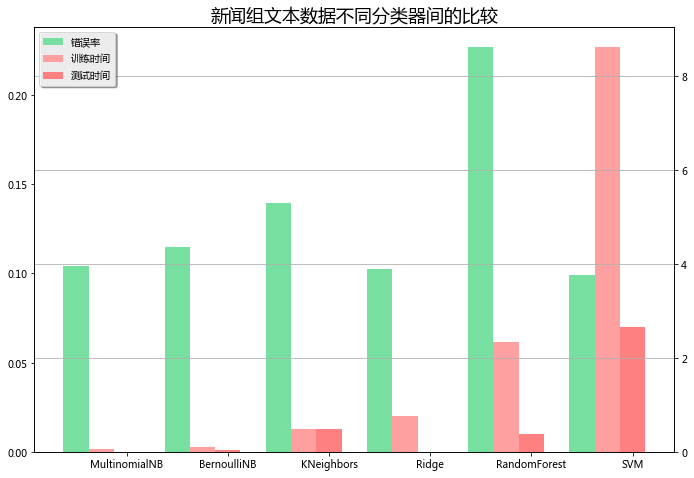

In [4]:
    plt.xticks(x+0.5, names)
    plt.legend([b1[0], b2[0], b3[0]], (u'错误率', u'训练时间', u'测试时间'), loc='upper left', shadow=True)
    plt.title(u'新闻组文本数据不同分类器间的比较', fontsize=18)
    plt.xlabel(u'分类器名称')
    plt.grid(True)
    plt.tight_layout(2)
    plt.show()